# Анализ оттока клиентов фитнес-клуба

Задача проекта - ислледование клиентской базы фитнес-клуба. Ее решение подразумевает прогнозирование оттока - определение того, какие из клиентов, наиболее вероятно, в следующем месяце перестанут к нам ходить, какие факторы на это влияют и как можно уменьшить отток. Кроме того, необходимо выделить основные целевые группы клиентов и сформулировать рекомендации по работе с ними. Для решения этих задач предполагается использовать методы машинного обучения. В качестве исходных данных мы имеем сведения из анкет клиентов. 

## Содержание <a id='contents'></a>
1. [Загрузка и подготовка данных](#prepair)
2. [Разведочный анализ данных](#eda)
3. [Прогнозирование оттока](#churn)
4. [Изучение целевых групп клиентов](#cluster)
5. [Общий вывод](#conclusions)

## 1. Загрузка и подготовка данных <a id='prepair'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

filterwarnings('ignore')
plt.style.use('seaborn')
plt.rcParams['figure.titlesize'] = 18

In [2]:
data = pd.read_csv(r'gym_churn.csv')

In [3]:
data.shape

(4000, 14)

In [4]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [6]:
# замена названий столбцов на более удобные
data.columns = data.columns.str.lower()
data.rename(columns = {
                'avg_additional_charges_total': 'add_charges', 
                'avg_class_frequency_total': 'avg_frequency',
                'avg_class_frequency_current_month': 'avg_frequency_cm',
                'month_to_end_contract': 'month_to_end'}, 
                inplace=True)

In [7]:
f'Общее число дубликатов: {data.duplicated().sum()}'

'Общее число дубликатов: 0'

Таблица содержит 4000 наблюдений и 14 столбцов. Данные достаточно "хорошие" - нет пропусков и дубликатов, все столбцы имеют числовые форматы. Рассмотрим данные более подробно с точки зрения построения на их основе моделей машинного обучения.

[Наверх](#contents)

## 2. Разведочный анализ данных <a id='eda'></a>

Для начального анализа данных рассмотрим распределения данных и их взаимные корреляции. 

In [8]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,add_charges,month_to_end,lifetime,avg_frequency,avg_frequency_cm,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


В фитнес-клубе примерно одинаковое количество мужчин и женщин (51/49%), средний возраст клиентов - 29 лет, четверть посетителей - от 18 до 27 лет, четверть - от 31 до 41 года, половина - от 27 до 31 года. Около 85% живут или работают неподалеку, почти половина - сотрудники компаний-партнеров, 30% пришли по приглашению друзей. В среднем клиенты посещают клуб меньше четырех месяцев, хотя и заключают договоры на более долгие сроки. В основном клиенты предпочитают короткие абонементы: при трех опциях (1, 6 и 12 месяцев) средняя продолжительность абонемента меньше 5 месяцев. Средний посетитель посещает клуб около двух раз в неделю, хотя и есть отдельные энтузиасты с 6 посещениями, причем этот показатель практически не отличается в текущем месяце и за все время, 40% клиентов посещают групповые занятия. В среднем клиенты дополнительно платят по 147 (того, в чем  нас меряются платежи), но этот показатель имеет достаточно большой разброс - 25% клиентов платят меньше 69, 25% - больше 210, в том числе есть совсем высокие значения - до 550, влияющие на среднее.

Большая часть признаков -  категориальные, кодированные цифрами. Средние значения и отклонения достаточно близки для срока договора и оставшегося срока договора, а также средней частоты посещений и средней частоты посещений за месяц - скорее всего, эти пары признаков коррелируют. Значения переменных (например, `age` и `avg_additional_charges_total`) очень сильно отличаются по величине, поэтому перед обучением моделей данные необходимо будет стандартизировать. Для более подробного изучения распределений поделим выборку на две группы в зависимости от значения целевой переменной (0 или 1 в столбце `churn`) и постоим сравнительные гистограммы.

In [9]:
churn = data[data['churn'] == 1]
no_churn = data[data['churn'] == 0]
f'Число оставшихся клиентов: {len(no_churn)}, число ушедших клиентов: {len(churn)}, отношение: {len(no_churn) / len(churn):.2f}'

'Число оставшихся клиентов: 2939, число ушедших клиентов: 1061, отношение: 2.77'

Таким образом, в нашем датасете примерно втрое больше оставшихся клиентов, однако число ушедших также достаточно велико.

In [10]:
data.pivot_table(index='churn', aggfunc=['mean', 'std']).T

churn                           0           1
mean add_charges       158.445715  115.082899
     age                29.976523   26.989632
     avg_frequency       2.024876    1.474995
     avg_frequency_cm    2.027882    1.044546
     contract_period     5.747193    1.728558
     gender              0.510037    0.510839
     group_visits        0.464103    0.268615
     lifetime            4.711807    0.990575
     month_to_end        5.283089    1.662582
     near_location       0.873086    0.768143
     partner             0.534195    0.355325
     phone               0.903709    0.902922
     promo_friends       0.353522    0.183789
std  add_charges        99.801599   77.696419
     age                 3.009933    2.895163
     avg_frequency       1.016006    0.694705
     avg_frequency_cm    1.018994    0.770237
     contract_period     4.716942    2.132371
     gender              0.499984    0.500118
     group_visits        0.498795    0.443448
     lifetime            3.874780    1.110799
     month_to_end        4.363522    1.964593
     near_location       0.332933    0.422217
     partner             0.498914    0.478837
     phone               0.295040    0.296204
     promo_friends       0.478144    0.387495

Как видно, у оставшихся посетителей больше средние значения дополнительных трат, частота посещений, продолжительность контрактов и время с первого обращения в клуб. Предположительно, эти факторы, характеризующие активность пользователей, определяют их склонность остаться. Абсолютные значения стандартных отклонений во второй группе также больше, что, возможно, объясняется большей численностью этой группы. Рассмотрим распределение отдельных признаков.

In [11]:
data.promo_friends.unique()

array([1, 0])

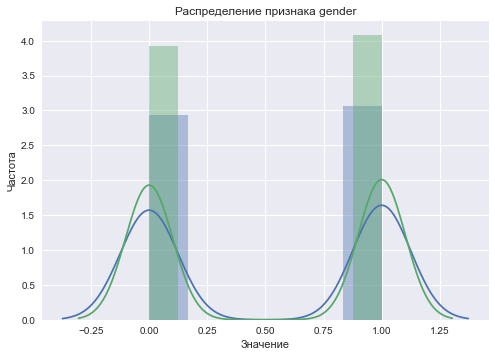

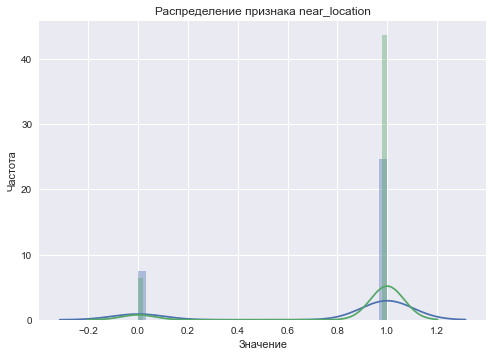

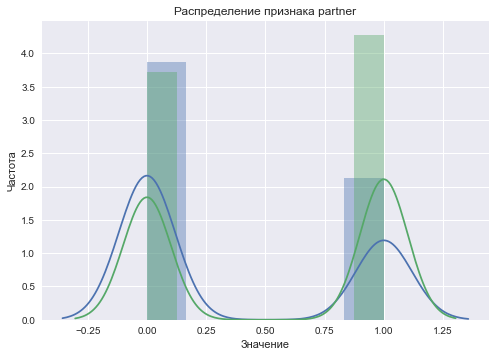

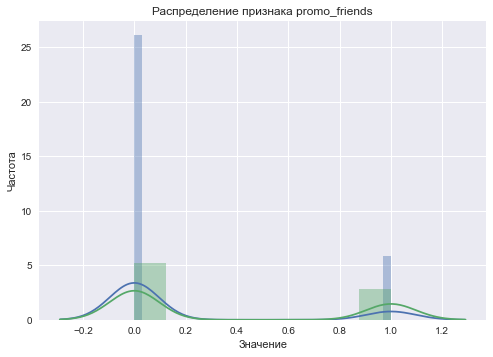

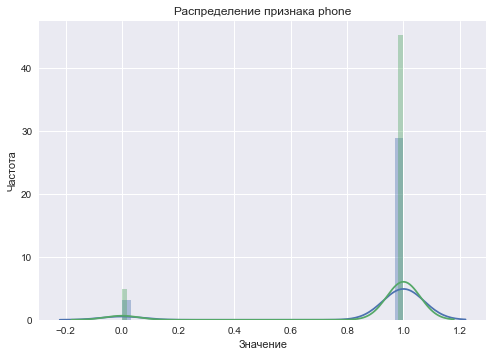

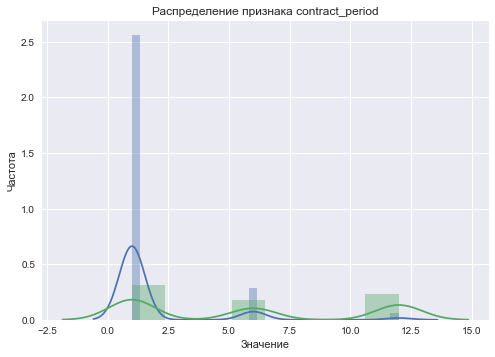

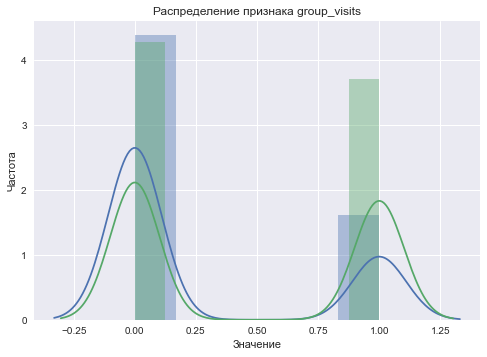

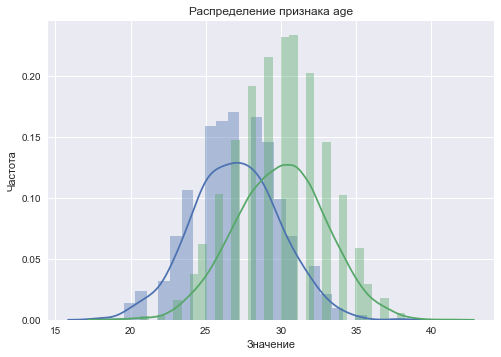

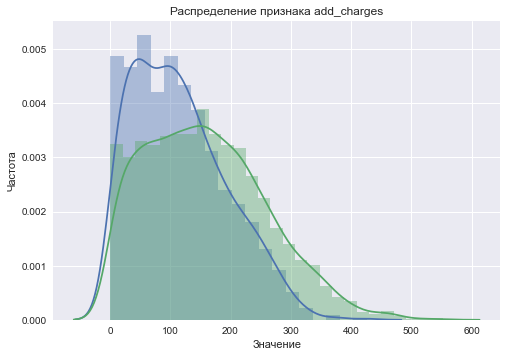

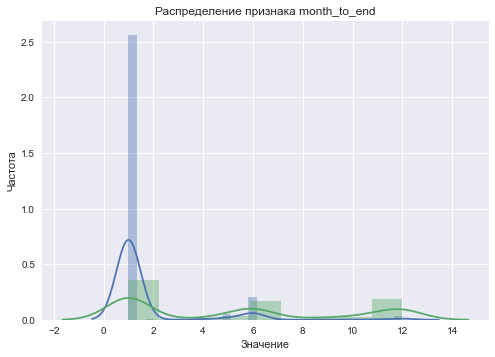

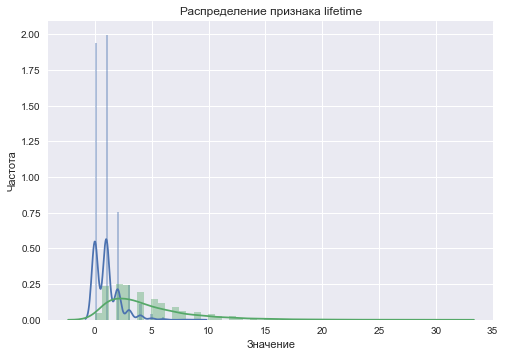

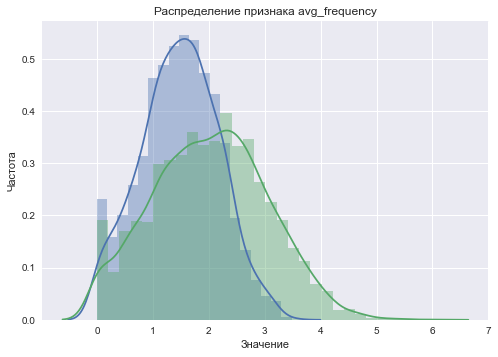

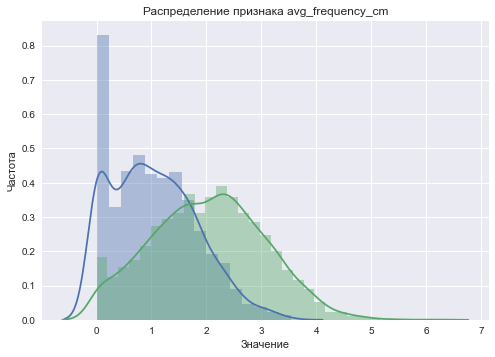

In [12]:
for col in data.columns[:-1]:
    sns.distplot(churn[col])
    sns.distplot(no_churn[col])
    plt.xlabel('Значение')
    plt.ylabel('Частота')
    plt.title(f'Распределение признака {col}')
    plt.show()

Категориальные данные (пол, переменные с буллевыми значениями, длительность договора) имеют дискретные распределения. Кроме них, дискретные распределения имеют возраст посетителей, т.к. он меряется в полных годах (напоминает нормальное); время пользования (напоминает распределение Пуассона); время до окончания абонемент (имеет три пика на 1, 6 и 12 месяцах - трех возможных сроках заключения договора).  
Распределения среднего числа посещений в течение месяца и в целом, а также дополнительных расходов напоминают нормальное, однако имеют большие значения около нуля и длинные хвосты справа.  
Еще раз отметим, что наблюдений без оттока больше, средние значения и отклонения у них больше.

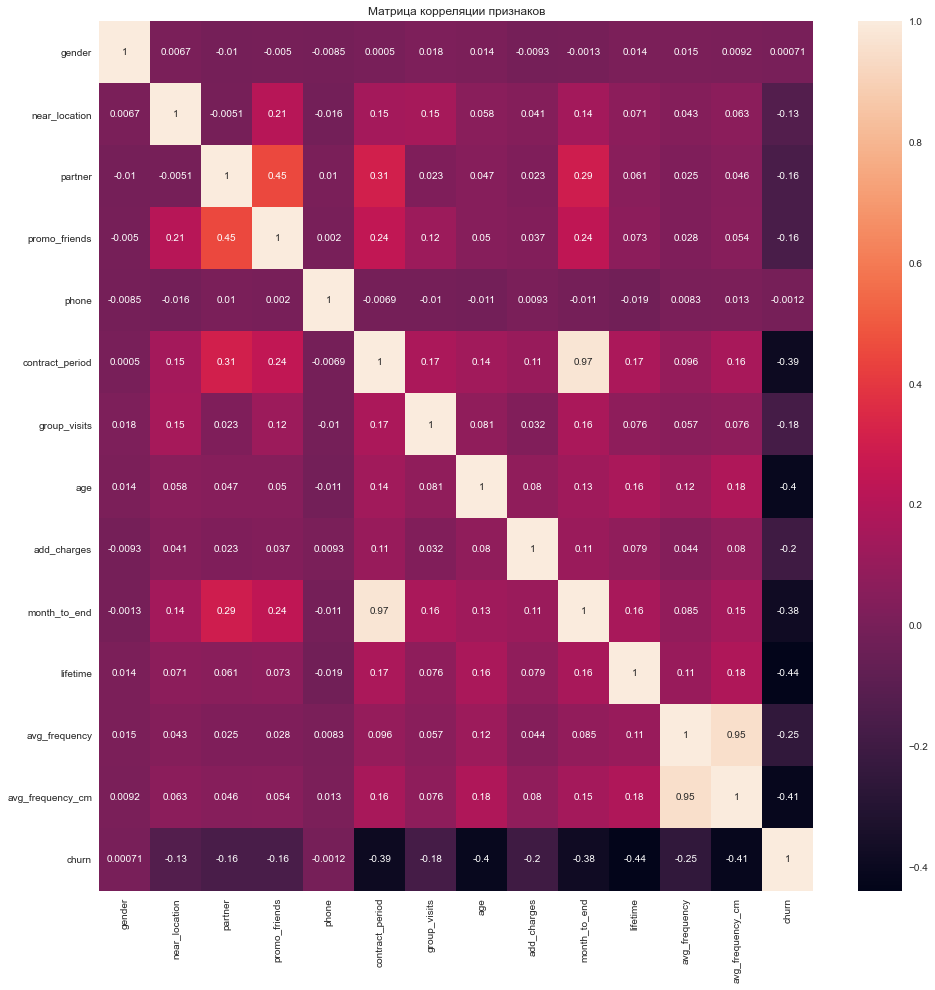

In [13]:
plt.figure(figsize=(16, 16))
sns.heatmap(data.corr(), annot=True)
plt.title('Матрица корреляции признаков')
plt.show()

Коррелирующих данных немного - очень высокая корреляция наблюдается только между сроком договора и число месяцев до конца (0.97) и частотой посещение в течение последнего месяца и всего (0.95). Исключим из датасета по одному из каждой пары коррелирующих признаков.

In [14]:
data_no_corr = data.drop(columns=['avg_frequency', 'contract_period'])

#### Выводы
1. Данные в таблице делятся на две группы - количественные и категориальные (кодированы числами).
2. Большая часть данным (почти три четверти) относится к оставшимся клиентам, однако данных по ушедшим клиентам также достаточно.
3. Можно предположить, что большое значение для прогнозирование оттока клиентов имеют показатели, характеризующие их "добровольную" вовлеченность: ожидается, что менее склонны уходить те клиенты, которые больше занимаются и больше платят сверх абонемента (например, за индивидуальные тренировки).

[Наверх](#contents)

## 3. Прогнозирование оттока <a id='churn'></a>

С точки зрения ML, прогнозирование оттока клиентов является задачей бинарной классификации. В данном случае у нас нет временных рядов, для прогнозирования мы будем использовать логистическую регрессию и случайный лес. Для оценки - метрики *precision*, *accuracy*, *recall* и F1-меру.

Для подготовки данных данных выделим из датасета целевую переменную и независимые признаки, разделим выборку на обучающую и валидационную, а также стандартизируем значения признаков, поскольку в исходных данных они сильно отличаются по абсолютным значениям.

In [15]:
class ClassifierChooser():
    '''
    Класс для автоматического отбора лучшей модели классификации. Методы:
        preprocessing(dataframe, target_index) - принимает датафрейм и индекс целевой переменной 
            (по умолчанию - последний стоблец), делит выборку на обучающую и тестовую 
            и стандартизирует независимые переменные; результаты хранятся в атрибутах класса
            X_train, X_test, X_train_st, X_test_st, y_train, y_test
        classifier_choice(models) - принимает словарь вида {название: модель}, обучает и сравнивает 
            модели на основе предобработанных данных (по метрикам precision, accuracy, recall, f1-мера), 
            сохраняет результат в виде словаря в атрибуте res и возвращает датафрейм с выделенными 
            лучшими метриками
            NB! Возможны ошибки при не уникальных именах моделей, которые обучаются на одном датасете!
        choose_best(name) - принимает название модели (см. выше про словарь), записывает в атрибут
            best_model параметры и метрики для лучшей модели в виде словаря, возвращает модель
    '''
    
    def __init__(self):
        self.res = []
        self.best_model = None
        
    def preprocessing(self, df, target_index=-1): 
        X = df.drop(columns = df.columns[target_index])
        y = df[df.columns[target_index]]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, 
                                                            random_state=42, test_size=0.2, stratify=y)
        scaler = StandardScaler()
        self.X_train_st = scaler.fit_transform(self.X_train)
        self.X_test_st = scaler.transform(self.X_test)
        
    def classifier_choice(self, models=dict): 
        for name in models:
            model = models[name]
            model.fit(self.X_train_st, self.y_train)
            y_pred = model.predict(self.X_test_st)
            self.res.append({
                'model': model,
                'model_name': name,
                'accuracy': accuracy_score(self.y_test, y_pred),
                'precision': precision_score(self.y_test, y_pred), 
                'recall': recall_score(self.y_test, y_pred),
                'f1-score': f1_score(self.y_test, y_pred),
            })
        
        def highlight_max(x): # выделение цветом лучших метрик
            return ['background-color: yellow' if v == x.max() else '' for v in x]
        
        res_table = pd.DataFrame(self.res).set_index('model_name').iloc[:, 1:]
        return res_table.style.apply(highlight_max)
    
    def choose_best(self, name):
        self.best_model = next(dct for dct in self.res if dct['model_name'] == name)
        return self.best_model['model']

In [16]:
models = {
    'LogisticRegression': LogisticRegression(random_state=42), 
    'RandomForest': RandomForestClassifier(random_state=42), 
}

In [17]:
a = ClassifierChooser()
a.preprocessing(data_no_corr)
a.classifier_choice(models)

,accuracy,precision,recall,f1-score
model_name,,,,
LogisticRegression,0.911250,0.850746,0.806604,0.828087
RandomForest,0.903750,0.842640,0.783019,0.811736


In [18]:
best_a = a.choose_best('LogisticRegression')

Как видно, лучший прогноз, с точки зрения всех метрик, дает логистическая регрессия. Для интерпретации модели проанализируем веса отдельных признаков.

In [19]:
importance_gb = pd.DataFrame({
                       'features': data_no_corr.columns[:-1],
                       'importance': best_a.coef_[0],
})

importance_gb.sort_values('importance', ascending=True)

,features,importance
9,lifetime,-3.804700
8,month_to_end,-1.388560
10,avg_frequency_cm,-1.274209
6,age,-1.191754
7,add_charges,-0.586902
5,group_visits,-0.368293
3,promo_friends,-0.195367
4,phone,-0.076772
1,near_location,-0.064777
2,partner,-0.038288


Отрицательные веса обозначают, что соответствующий фактор _не_ способствует уходу клиента, и чем  выше абсолютное значение веса, тем сильнее он влияет.

#### Выводы
1. Лучший прогноз на тестовой выборке показала логистическая регрессия, однако модель не очень хороша: доля правильных ответов превышает 90%, однако точность и полнота не очень высокие. Задача заключается в том, чтобы с помощью модели предсказать тех клиентов, которые могут нас покинуть, чтобы мы смогли предпринять какие-то действия для предотвращения этого, так что точность и полнота для нас крайне важны, а следовательно, модель в дальнейшем следует улучшать.
2. Тем не менее возможно выделить признаки, которые удерживают клиента: это общее время посещения клуба, оставшаяся продолжительность абонемента, частота посещений и возраст. Влияют также привлечение клиента к групповым занятиям, а также дополнительные траты на фитнес.

[Наверх](#contents)

## 4. Изучение целевых групп клиентов <a id='cluster'></a>

Для выделения целевых групп клиентов применим кластерный анализ. Для начала стандартизируем имеющиеся данные, затем с помощью иерархической кластеризации оценим возможно число кластеров и поделим клиентов на кластеры с помощью метода K средних.

In [20]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(data[data.columns[:-1]])
linked = linkage(X_sc, method = 'ward')

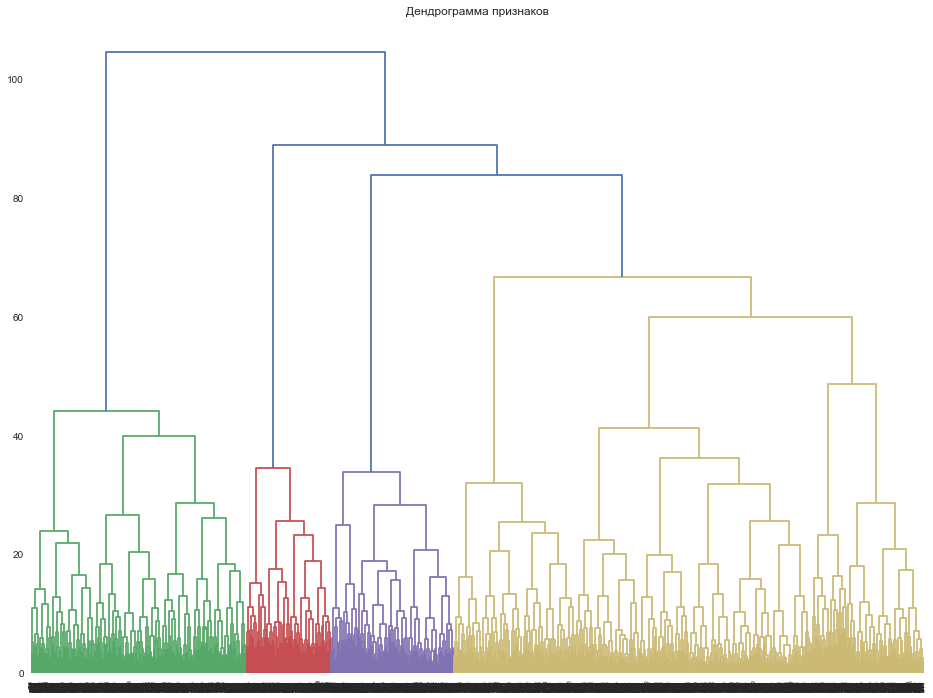

CPU times: user 1min 22s, sys: 15.1 s, total: 1min 37s
Wall time: 1min 38s


In [21]:
%%time

plt.figure(figsize=(16, 12))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма признаков')
plt.show() 

На основании этого графика можно предположить, что следует выделить четыре кластера. Однако, скорее, целесообразно разделить самый большой кластер (объединяющий почти половину наблюдений) на несколько частей. Применим к данным метод k средних с `n=5`.

In [22]:
km = KMeans(n_clusters=5, random_state=42) 
labels = km.fit_predict(X_sc)
data['cluster'] = labels

In [23]:
data.pivot_table(index=['cluster'], aggfunc={'age': 'count'})

,age
cluster,
0,633
1,889
2,865
3,1227
4,386


In [24]:
data.pivot_table(index=['cluster'])

,add_charges,age,avg_frequency,avg_frequency_cm,churn,contract_period,gender,group_visits,lifetime,month_to_end,near_location,partner,phone,promo_friends
cluster,,,,,,,,,,,,,,
0,141.774331,29.104265,1.770536,1.669581,0.246445,3.097946,0.502370,0.448657,3.772512,2.887836,0.949447,0.829384,1,0.998420
1,159.774265,30.008999,2.745505,2.733173,0.089989,2.606299,0.554556,0.436445,4.780652,2.419573,0.849269,0.263217,1,0.052868
2,163.509804,29.905202,2.006405,1.998179,0.021965,11.854335,0.499422,0.546821,4.677457,10.812717,0.937572,0.737572,1,0.478613
3,129.496414,28.083945,1.225192,0.967967,0.572942,1.914425,0.485738,0.276284,2.195599,1.821516,0.718011,0.299919,1,0.018745
4,144.208179,29.297927,1.854211,1.723967,0.266839,4.777202,0.523316,0.427461,3.940415,4.466321,0.862694,0.471503,0,0.305699


In [25]:
num_cols = ['month_to_end', 'lifetime', 'avg_frequency', 'avg_frequency_cm', 'age', 'add_charges']
dis_cols = ['contract_period', 'gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']

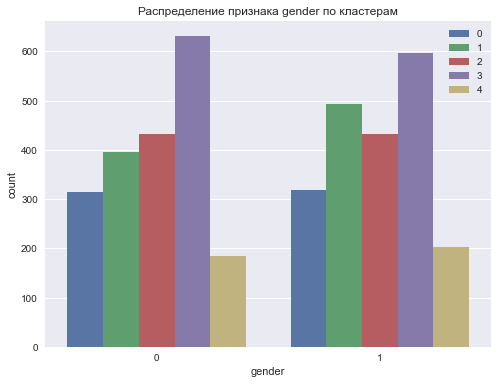

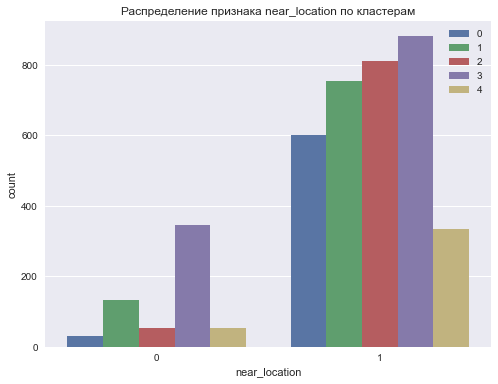

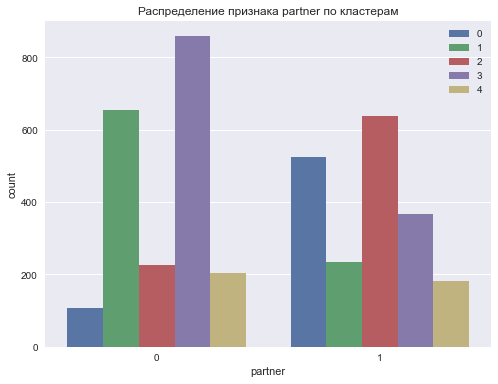

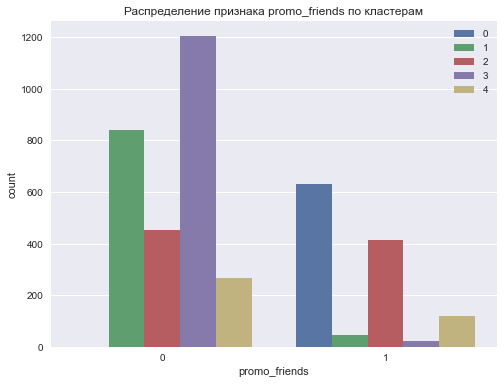

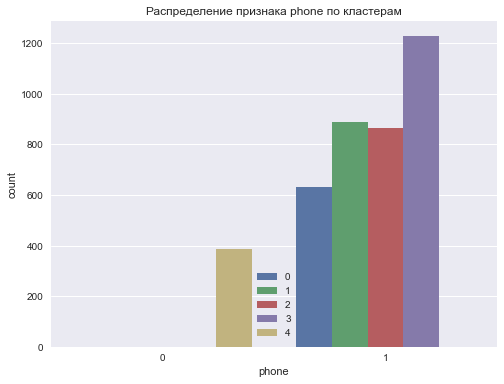

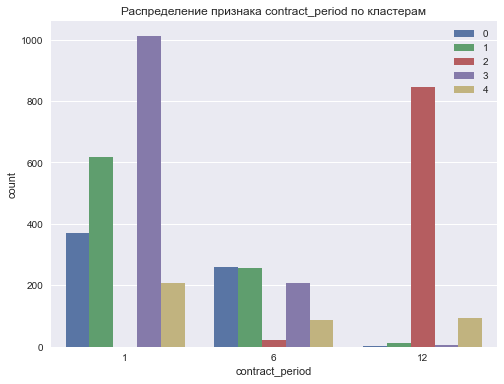

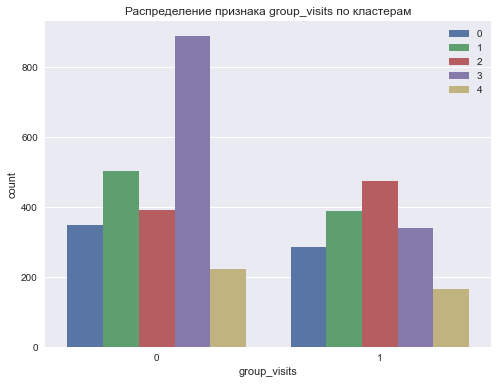

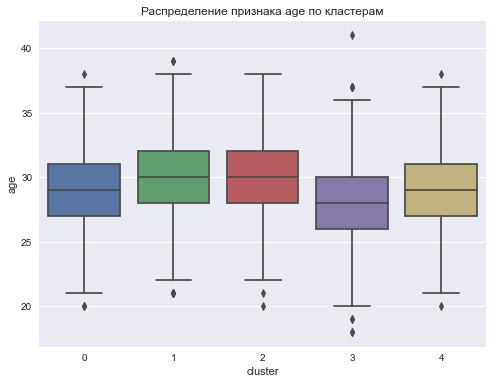

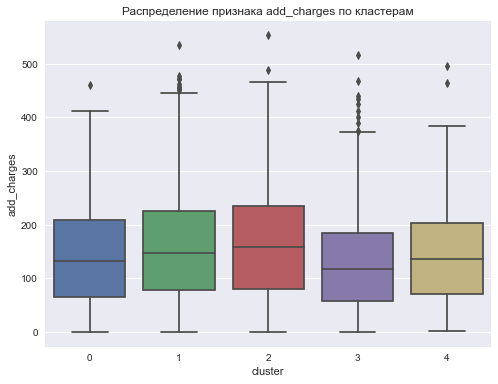

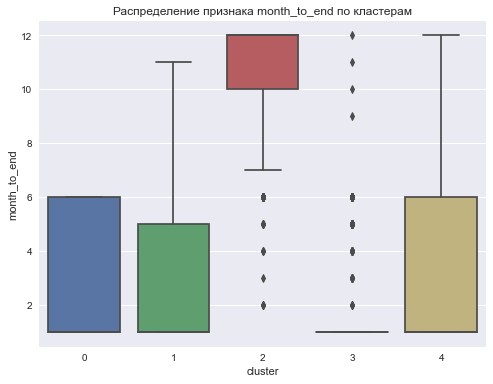

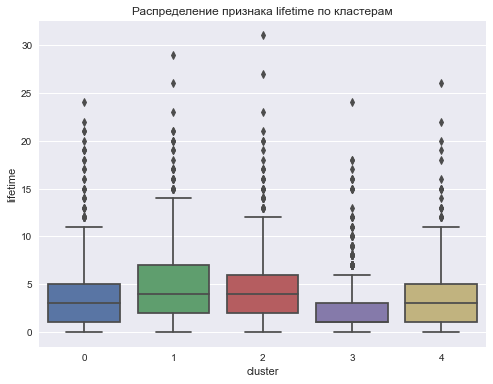

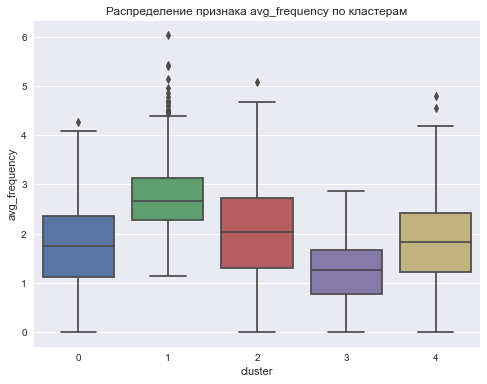

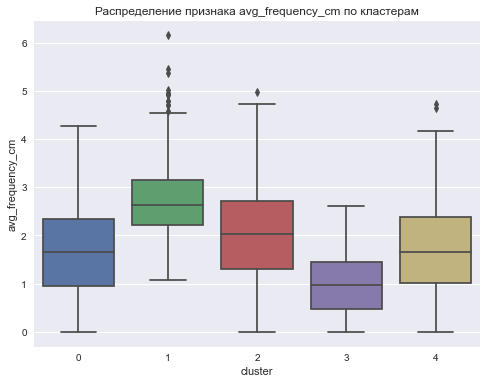

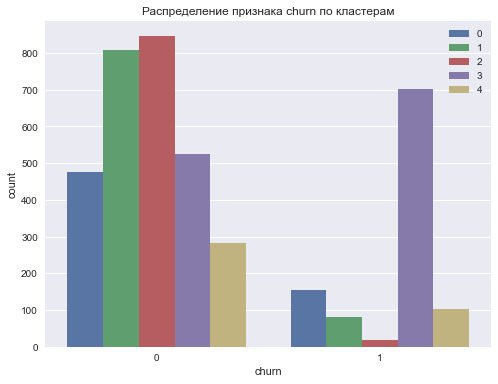

In [26]:
for col in data.columns[:-1]:
    plt.figure(figsize=(8,6))
    plt.title(f'Распределение признака {col} по кластерам')
    if col in num_cols:
        sns.boxplot(data=data, y=col, x='cluster')
    if col in dis_cols:
        sns.countplot(data=data, x=col, hue='cluster')
        plt.legend()
    plt.show()

#### Вывод
1. Самая низкая доля оттока (2%) - в кластере 2, объединяющем примерно 860 человек с длинными абонементами и высокими тратами сверх него. Такие клиенты посещают клуб примерно по два раза в неделю, в основном живут или работают поблизости, примерно в 75% случаев работают в компаниях-партнерах и в половине случаев их приводят друзья.
2. Низкая доля оттока также в кластере 1 (9%), в котором около 890 человек, в среднем самых старших, тратящих достаточно много денег (по этому показателю 1 и 2 кластеры очень близки). Клиенты из этого кластера занимаются больше, чем клиенты из кластера 1 (и по числу посещений и по групповым занятиям), однако покупают более значительно более короткие абонементы. 
3. Кластеры 0 (630 человек) и 4 (386 человек) очень близки по доле оттока (24 и 26%) и целому ряду других показателей - дополнительным платежам, возрасту, частоте и "стажу" занятий и интересу к групповым занятиям. Люди из кластера 4 имеют заметно большую среднюю продолжительность абонементов (второй показатель, превосходят даже кластер 1), тогда как в кластере 0 очень высокие доли пользователей, живущий/работающих поблизости (95%), сотрудников компаний-партнеров (83%) и пришедших от друзей (99.8%), что, по-видимому, компенсирует длительность абонемента. 
4. Кластер 3 самый большой - 1252 человека - и проигрывает прочим кластерам по всем показателям. Клиенты здесь самые молодые, реже и меньше всего ходят, редко выбирают групповые программы и т.д. Доля оттока здесь очень высока - 57%.

[Наверх](#contents)

## 5. Общий вывод <a id=#conclusions></a>

1. В ходе работы над проектом были построена модель ML для прогнозирования оттока клиентов. Лучший из рассмотренных вариантов - логистическая регрессия, однако качество модели недостаточно для полноценного предсказания, она нуждается в доработке. Также был проведен кластерный анализ: выделено пять групп клиентов и проанализированы особенности их поведения с точки зрения склонности к уходу.
2. Наиболее значимые факторы, делающие отток менее вероятным - это общий "стаж" посещения клуба, продолжительность текущего абонемента, а также активность занятий: частота посещений, траты сверх абонемента, участие в групповых занятиях. При этом небольшая длительность абонемента может в некоторой мере компенсироваться "социальными связями клиента" - его работой в компании-партнере, или привлечение другом, однако так
3. Соответственно, стратегия удержания пользователей должна основываться на продаже более длинных абонементов (например, можно устраивать акции со скидками исключительно на годовые абонементы или добавлять к ним какие-то бонусы вроде нескольких бесплатных индивидуальных тренировок), а также на том, чтобы побудить клиентов заниматься активнее. Например, можно давать скидки на групповые занятия или включать несколько пробных групповых занятий в состав абонементов. Либо адресно обращаться к клиентам, у которых снижается частота посещений.

[Наверх](#contents)